# Import libs & Dataset

In [30]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

from alibi_detect.cd import KSDrift, MMDDrift
from alibi_detect.cd.preprocess import UAE

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff

import scipy as sp
from scipy import stats
from scipy.spatial.distance import pdist
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance
from statsmodels.stats.multitest import multipletests
import statsmodels.stats.api as sms

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score

from sklearn.model_selection import StratifiedKFold as StratifiedKFold

import lime
import lime.lime_tabular
import shap

import gower

import logging

In [2]:
OUTPUT_FILE = "houseprices.csv"

houseprices_df = pd.read_csv(OUTPUT_FILE)
houseprices_df.drop(["id","date"], axis=1, inplace=True)
houseprices_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Prepare dataset for the model : train as baseline, test as target 

In [72]:
baseline_df, target_df = train_test_split(houseprices_df, test_size=0.2, random_state=10)

print("Baseline dataset size: " + str(len(houseprices_train)))
print("Target dataset size: " + str(len(houseprices_test)))

Baseline dataset size: 17290
Target dataset size: 4323


# Initial EDA

In [16]:
continous_cols = ['price',  'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 
                  'lat','long','sqft_living15', 'sqft_lot15']

categorical_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode']

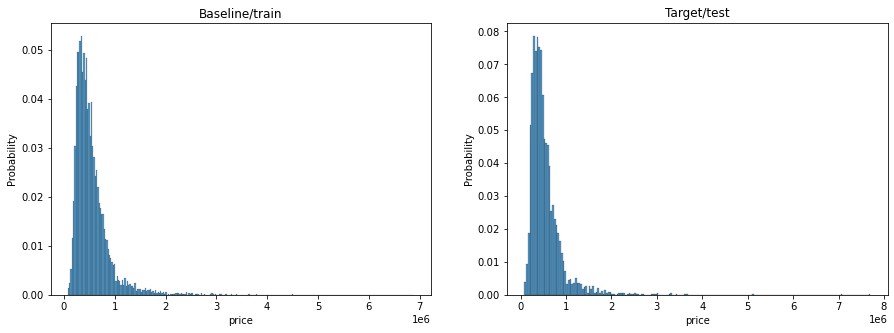

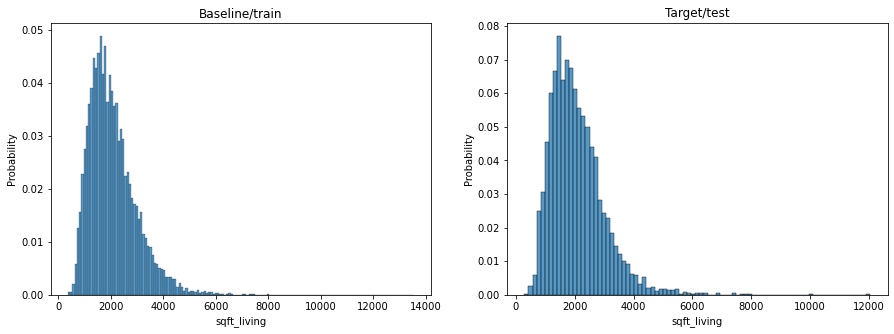

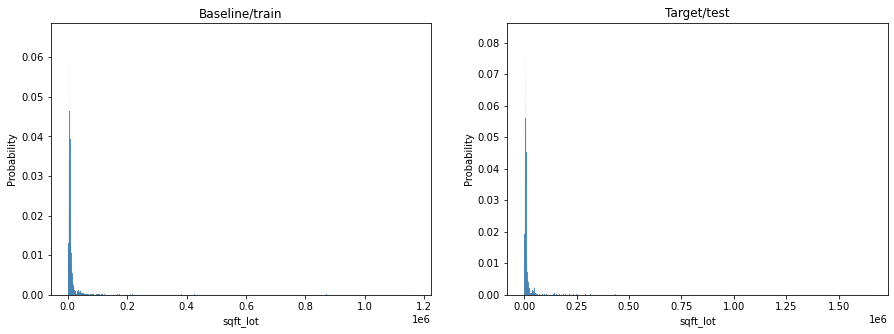

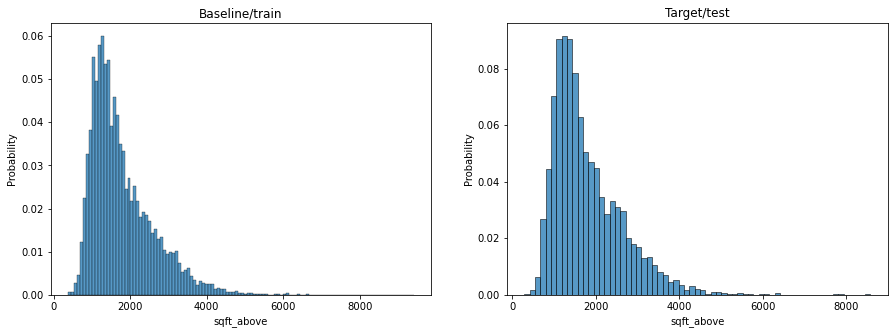

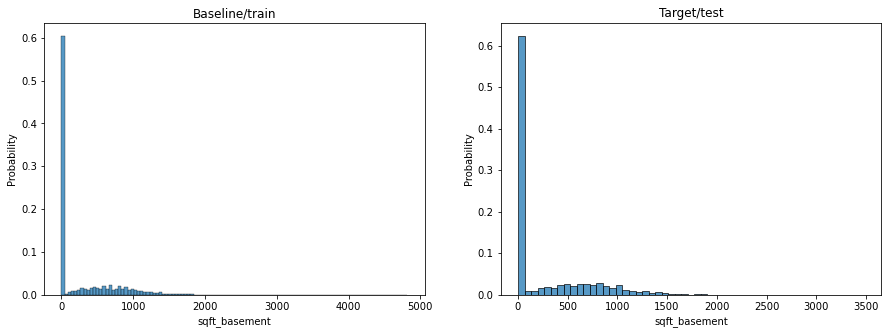

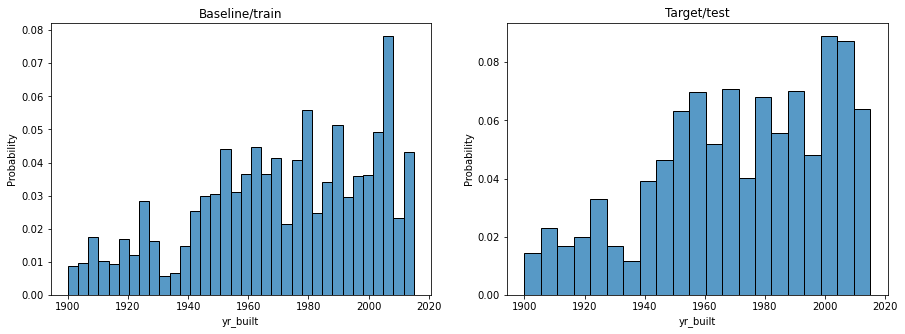

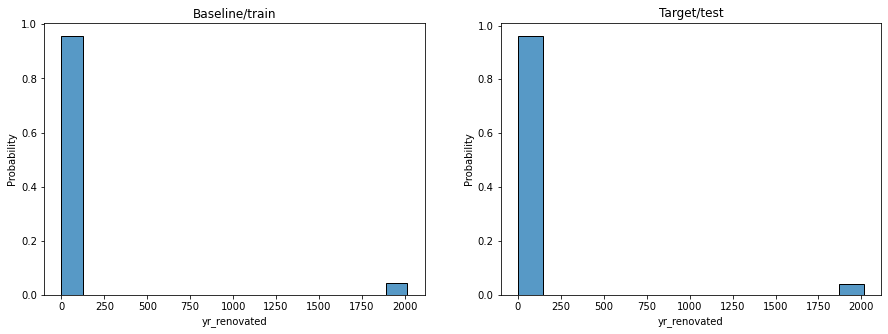

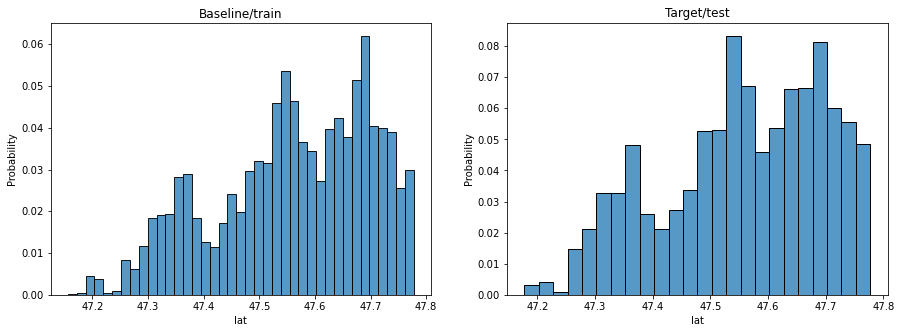

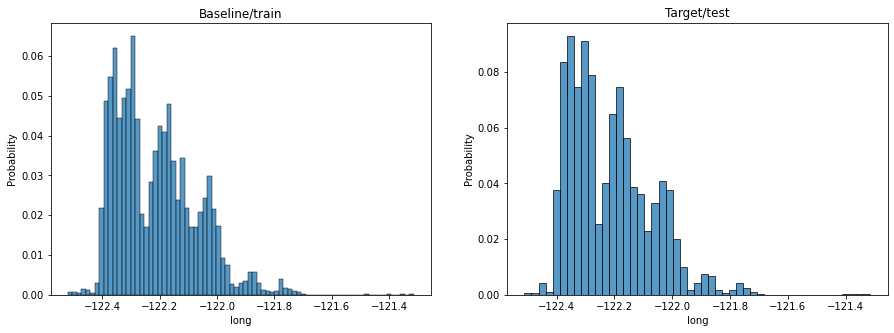

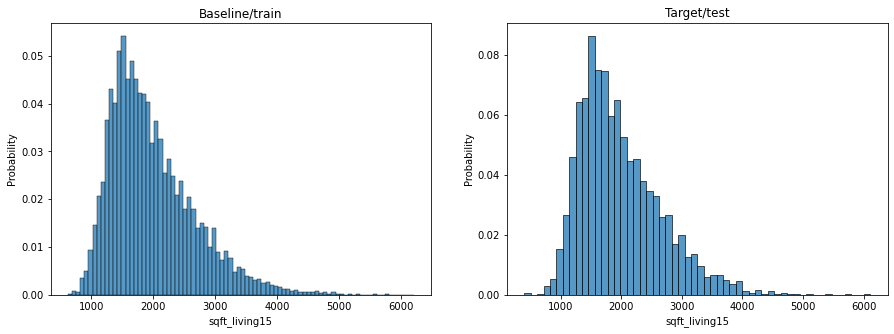

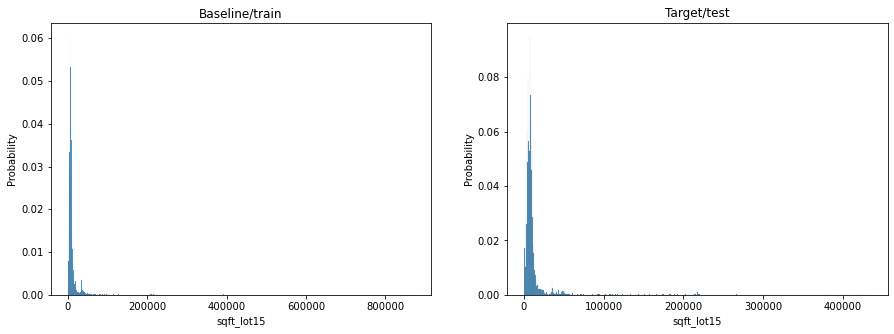

In [21]:
for col in continous_cols:
    baseline = baseline_df.loc[:,col]
    target = target_df.loc[:,col]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15, 5))
    sns.histplot(x=baseline, ax=ax1, stat='probability').set(title="Baseline/train")
    sns.histplot(x=target, ax=ax2, stat='probability').set(title="Target/test")

# Technique 1: Null Hypothesis testing using KS-test

In [73]:
pvalues = []
data = []

for col in continous_cols:
    
    baseline = baseline_df.loc[:,col]
    target = target_df.loc[:,col]
    
    d_stat, p_val = stats.ks_2samp(baseline, target,mode='asymp')
    pvalues.append(p_val.round(2))
    data.append([col,p_val.round(2)])
    
d_stat, p_val = stats.combine_pvalues(pvalues, method='fisher')        
data.append(["overall", p_val.round(2)])

data_df = pd.DataFrame(data, columns=["Feature", "PValue"])
data_df

,Feature,PValue
0,price,0.53
1,sqft_living,0.76
2,sqft_lot,0.93
3,sqft_above,0.65
4,sqft_basement,0.12
5,yr_built,0.58
6,yr_renovated,1.00
7,lat,0.38
8,long,0.24
9,sqft_living15,0.97


In [112]:
categorical_cols = ['floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode'] #bedrooms bathrooms

pvalues = []
data = []

for col in categorical_cols:
    
    baseline = baseline_df.loc[:,col].to_numpy()
    target = target_df.loc[:,col].to_numpy()
    
    unique, counts = np.unique(baseline, return_counts=True)
    baseline_freq = counts / len(baseline)
    
    unique, counts = np.unique(target, return_counts=True)
    target_freq = counts / len(target)
    
    d_stat, p_val = stats.chisquare(target_freq, f_exp=baseline_freq)
            
    pvalues.append(p_val.round(2))
    data.append([col,p_val.round(2)])
    
data_df = pd.DataFrame(data, columns=["Feature", "PValue"])
data_df

,Feature,PValue
0,floors,1.0
1,waterfront,1.0
2,view,1.0
3,condition,1.0
4,grade,1.0
5,zipcode,1.0


# Technique 2: Comparing stats like Confidence intervals

In [74]:
def confidence_interval(series):
       return sms.DescrStatsW(series).tconfint_mean()

def confidence_interval_for_diff_in_mean(baseline, target):
    n1 = len(baseline)
    n2 = len(target)
    mean_baseline = np.mean(baseline.values)
    mean_target = np.mean(target.values)
    sd_baseline = np.std(baseline.values)
    sd_target = np.std(target.values)
    
    mean_d = mean_baseline - mean_target
    
    ## standard error for mean
    sem_baseline = sd_baseline / np.sqrt(n1)
    sem_target = sd_target / np.sqrt(n2)

    ## difference in standard error
    sem_d = (np.sqrt((n1-1)*sem_baseline**2 + (n2-1)*sem_target**2)/(n1+n2-2))*(np.sqrt(1/n1 + 1/n2))
    
    lcb = (mean_d - 1.96*sem_d).round()  #lower limit of the CI
    ucb = (mean_d + 1.96*sem_d).round()  #upper limit of the CI
    
    return (lcb,ucb)

def cohens_d(baseline, target):
    n1 = len(baseline)
    n2 = len(target)
    
    mean_baseline = np.mean(baseline.values)
    mean_target = np.mean(target.values)
    
    sd_baseline = np.std(baseline.values)
    sd_target = np.std(target.values)
    
    sd_pooled = np.sqrt((np.square(sd_baseline) + np.square(sd_target))/2)
    #sd_pooled2 =  np.sqrt((np.var(baseline.values)*(n1-1) + np.var(target.values)*(n2-1)) / (n1 + n2 - 2))
    
    d = abs((mean_baseline - mean_target) / sd_pooled).round(2)
    
    return d
    
cis = []
data = []

for col in continous_cols:
    
    baseline = baseline_df.loc[:,col]
    target = target_df.loc[:,col]
    
    ci_baseline = confidence_interval(baseline)
    ci_baseline = (ci_baseline[0].round(), ci_baseline[1].round())
    
    ci_target = confidence_interval(target)
    ci_target = (ci_target[0].round(), ci_target[1].round())
    
    #CI for difference in mean
    ci_diff_in_mean = confidence_interval_for_diff_in_mean(baseline, target)
    
    #cohen's D
    cohen_d = cohens_d(baseline, target)
    
    cis.append([col, ci_baseline, ci_target, ci_diff_in_mean, cohen_d
               ])
    
cis_df = pd.DataFrame(cis, columns=["Feature", "CI_baseline", "CI_target",
                                    "CI_diff_in_mean", "Cohen's_D"
                                   ])
cis_df

,Feature,CI_baseline,CI_target,CI_diff_in_mean,Cohen's_D
0,price,"(534828.0, 545658.0)","(528069.0, 550866.0)","(775.0, 776.0)",0.00
1,sqft_living,"(2067.0, 2094.0)","(2051.0, 2106.0)","(2.0, 2.0)",0.00
2,sqft_lot,"(14377.0, 15556.0)","(14231.0, 17106.0)","(-702.0, -702.0)",0.02
3,sqft_above,"(1774.0, 1798.0)","(1773.0, 1823.0)","(-12.0, -12.0)",0.01
4,sqft_basement,"(288.0, 301.0)","(268.0, 294.0)","(14.0, 14.0)",0.03
5,yr_built,"(1970.0, 1971.0)","(1971.0, 1972.0)","(-1.0, -1.0)",0.02
6,yr_renovated,"(80.0, 92.0)","(67.0, 90.0)","(8.0, 8.0)",0.02
7,lat,"(48.0, 48.0)","(48.0, 48.0)","(0.0, 0.0)",0.02
8,long,"(-122.0, -122.0)","(-122.0, -122.0)","(0.0, 0.0)",0.02
9,sqft_living15,"(1979.0, 1999.0)","(1957.0, 1997.0)","(12.0, 12.0)",0.02


In [ ]:
categorical_cols = ['floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode'] #bedrooms bathrooms

pvalues = []
data = []

for col in categorical_cols:
    
    baseline = baseline_df.loc[:,col].to_numpy()
    target = target_df.loc[:,col].to_numpy()
    
    unique, counts = np.unique(baseline, return_counts=True)
    baseline_freq = counts / len(baseline)
    
    unique, counts = np.unique(target, return_counts=True)
    target_freq = counts / len(target)
    
    d_stat, p_val = stats.chisquare(target_freq, f_exp=baseline_freq)
            
    pvalues.append(p_val.round(2))
    data.append([col,p_val.round(2)])
    
data_df = pd.DataFrame(data, columns=["Feature", "PValue"])
data_df

# Repeat above analysis on a different target dataset with drift

In [114]:
target_drift_df = target_df.copy()
target_drift_df["sqft_living"] = target_drift_df["sqft_living"].apply(lambda x: (x+1000))
target_drift_df["floors"] = target_drift_df["floors"].apply(lambda x: 3)

target_drift_df["sqft_living"]

957      3100
14143    3230
19452    1290
20510    2390
18354    2700
         ... 
5349     2690
11082    3240
4413     4740
17461    2720
9848     2610
Name: sqft_living, Length: 4323, dtype: int64

## Initial EDA

[Text(0.5, 1.0, 'Target/test')]

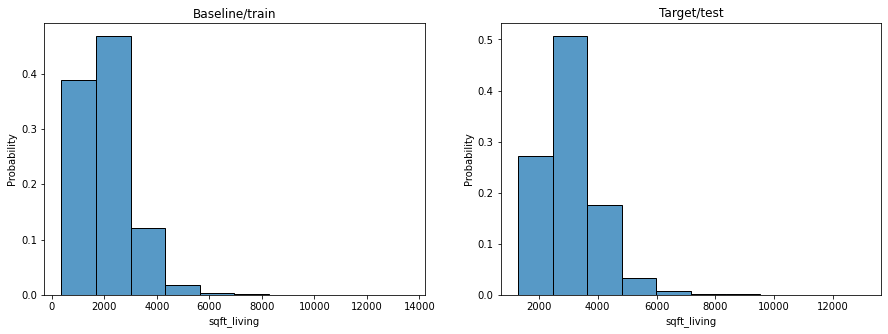

In [85]:
col = "sqft_living"
baseline = baseline_df.loc[:,col]
target = target_drift_df.loc[:,col]

fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15, 5))
sns.histplot(x=baseline, ax=ax1, stat='probability', bins=10).set(title="Baseline/train")
sns.histplot(x=target, ax=ax2, stat='probability', bins=10).set(title="Target/test")

[Text(0.5, 1.0, 'Target/test')]

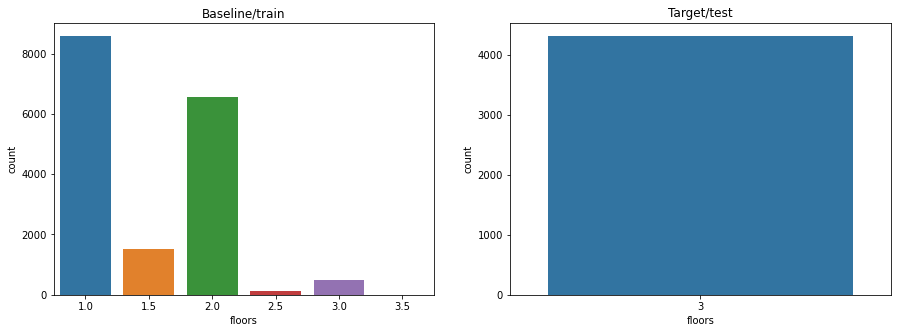

In [117]:
col = "floors"
baseline = baseline_df.loc[:,col]
target = target_drift_df.loc[:,col]

fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15, 5))
sns.countplot(x=baseline, ax=ax1).set(title="Baseline/train")
sns.countplot(x=target, ax=ax2).set(title="Target/test")

## Technique 1: Null Hypothesis testing using KS-test

In [89]:
pvalues = []
data = []

for col in continous_cols:
    
    baseline = baseline_df.loc[:,col]
    target = target_drift_df.loc[:,col]
    
    d_stat, p_val = stats.ks_2samp(baseline, target,mode='asymp')
    pvalues.append(p_val.round(2))
    data.append([col,p_val.round(2)])
    
d_stat, p_val = stats.combine_pvalues(pvalues, method='fisher')        
data.append(["overall", p_val.round(2)])

data_df = pd.DataFrame(data, columns=["Feature", "PValue"])
data_df

C:\Users\I301903\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:6895: RuntimeWarning:

divide by zero encountered in log



,Feature,PValue
0,price,0.53
1,sqft_living,0.00
2,sqft_lot,0.93
3,sqft_above,0.65
4,sqft_basement,0.12
5,yr_built,0.58
6,yr_renovated,1.00
7,lat,0.38
8,long,0.24
9,sqft_living15,0.97


In [118]:
pvalues = []
data = []

for col in categorical_cols:
    
    baseline = baseline_df.loc[:,col].to_numpy()
    target = target_drift_df.loc[:,col].to_numpy()
    
    unique, counts = np.unique(baseline, return_counts=True)
    baseline_freq = counts / len(baseline)
    
    unique, counts = np.unique(target, return_counts=True)
    target_freq = counts / len(target)
    
    d_stat, p_val = stats.chisquare(target_freq, f_exp=baseline_freq)
            
    pvalues.append(p_val.round(2))
    data.append([col,p_val.round(2)])
    
data_df = pd.DataFrame(data, columns=["Feature", "PValue"])
data_df

,Feature,PValue
0,floors,0.0
1,waterfront,1.0
2,view,1.0
3,condition,1.0
4,grade,1.0
5,zipcode,1.0


## Technique 2: Comparing stats like Confidence intervals

In [91]:
def confidence_interval(series):
       return sms.DescrStatsW(series).tconfint_mean()

def confidence_interval_for_diff_in_mean(baseline, target):
    n1 = len(baseline)
    n2 = len(target)
    mean_baseline = np.mean(baseline.values)
    mean_target = np.mean(target.values)
    sd_baseline = np.std(baseline.values)
    sd_target = np.std(target.values)
    
    mean_d = mean_baseline - mean_target
    
    ## standard error for mean
    sem_baseline = sd_baseline / np.sqrt(n1)
    sem_target = sd_target / np.sqrt(n2)

    ## difference in standard error
    sem_d = (np.sqrt((n1-1)*sem_baseline**2 + (n2-1)*sem_target**2)/(n1+n2-2))*(np.sqrt(1/n1 + 1/n2))
    
    lcb = (mean_d - 1.96*sem_d).round()  #lower limit of the CI
    ucb = (mean_d + 1.96*sem_d).round()  #upper limit of the CI
    
    return (lcb,ucb)

def cohens_d(baseline, target):
    n1 = len(baseline)
    n2 = len(target)
    
    mean_baseline = np.mean(baseline.values)
    mean_target = np.mean(target.values)
    
    sd_baseline = np.std(baseline.values)
    sd_target = np.std(target.values)
    
    sd_pooled = np.sqrt((np.square(sd_baseline) + np.square(sd_target))/2)
    #sd_pooled2 =  np.sqrt((np.var(baseline.values)*(n1-1) + np.var(target.values)*(n2-1)) / (n1 + n2 - 2))
    
    d = abs((mean_baseline - mean_target) / sd_pooled).round(2)
    
    return d
    
cis = []
data = []

for col in continous_cols:
    
    baseline = baseline_df.loc[:,col]
    target = target_drift_df.loc[:,col]
    
    ci_baseline = confidence_interval(baseline)
    ci_baseline = (ci_baseline[0].round(), ci_baseline[1].round())
    
    ci_target = confidence_interval(target)
    ci_target = (ci_target[0].round(), ci_target[1].round())
    
    #CI for difference in mean
    ci_diff_in_mean = confidence_interval_for_diff_in_mean(baseline, target)
    
    #cohen's D
    cohen_d = cohens_d(baseline, target)
    
    cis.append([col, ci_baseline, ci_target, ci_diff_in_mean, cohen_d
               ])
    
cis_df = pd.DataFrame(cis, columns=["Feature", "CI_baseline", "CI_target",
                                    "CI_diff_in_mean", "Cohen's_D"
                                   ])
cis_df

,Feature,CI_baseline,CI_target,CI_diff_in_mean,Cohen's_D
0,price,"(534828.0, 545658.0)","(528069.0, 550866.0)","(775.0, 776.0)",0.00
1,sqft_living,"(2067.0, 2094.0)","(3051.0, 3106.0)","(-998.0, -998.0)",1.08
2,sqft_lot,"(14377.0, 15556.0)","(14231.0, 17106.0)","(-702.0, -702.0)",0.02
3,sqft_above,"(1774.0, 1798.0)","(1773.0, 1823.0)","(-12.0, -12.0)",0.01
4,sqft_basement,"(288.0, 301.0)","(268.0, 294.0)","(14.0, 14.0)",0.03
5,yr_built,"(1970.0, 1971.0)","(1971.0, 1972.0)","(-1.0, -1.0)",0.02
6,yr_renovated,"(80.0, 92.0)","(67.0, 90.0)","(8.0, 8.0)",0.02
7,lat,"(48.0, 48.0)","(48.0, 48.0)","(0.0, 0.0)",0.02
8,long,"(-122.0, -122.0)","(-122.0, -122.0)","(0.0, 0.0)",0.02
9,sqft_living15,"(1979.0, 1999.0)","(1957.0, 1997.0)","(12.0, 12.0)",0.02
